https://youtu.be/JIPbilHxFbI

# An introduction to Detectron2 <p>

Using different models from the library to demonstrate it's capabilities

Using pre-trained models for instance and panoptic segmentation

Install the Detectron2 library

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 16.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 15837 (delta 30), reused 16 (delta 15), pack-reused 15770 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (11532/11532), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your 

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
#from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Read an image

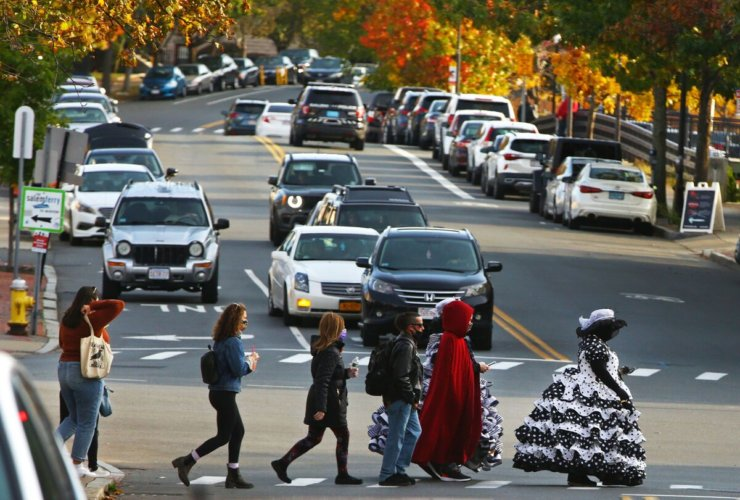

In [4]:
my_new_image = cv2.imread("Untitled.png")
cv2_imshow(my_new_image)

**Keypoint detection model** <p>
Keypoints are specific locations or landmarks in an image that are distinctive and informative. These keypoints are selected because they represent significant variations in the local image region and can be reliably detected and matched across different images.

model_final_a6e10b.pkl: 237MB [00:01, 172MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


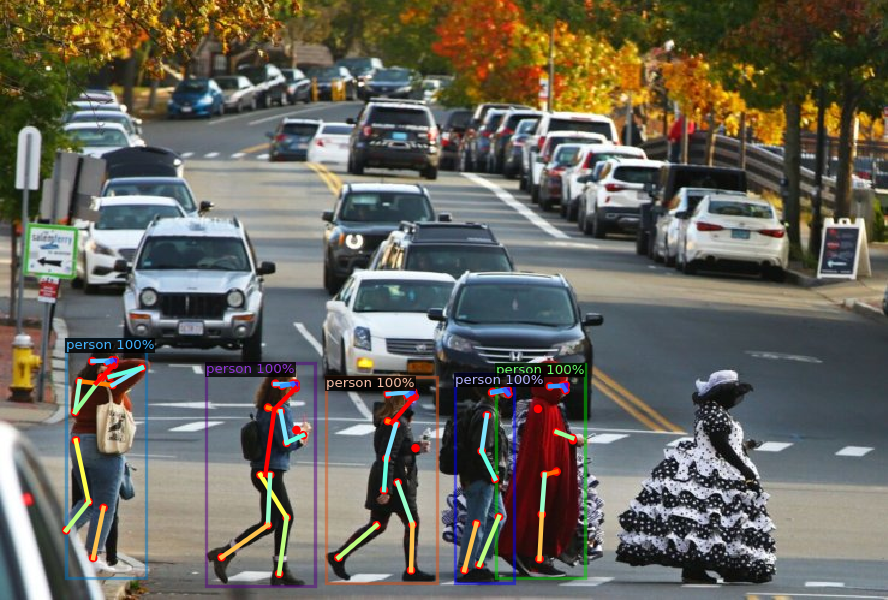

In [5]:
# Inference with a keypoint detection model
cfg_keypoint = get_cfg()   # get a fresh new config file
cfg_keypoint.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")) # File of pretrained model
cfg_keypoint.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# This is the threshold for the model to classify a object indentified as belonging to a certain class.
# Higher the thresh hold, lesser number of objects will be detected, but those will be very accurate -> Lower is vice versa
# Range: 0.5 - 0.8. But for scientific research most commonly used = 0.6 - 0.7
cfg_keypoint.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml") # Get the model weights
predictor = DefaultPredictor(cfg_keypoint) # This is like the instantiation of the model
outputs = predictor(my_new_image) # Getting prediction from model
v = Visualizer(my_new_image[:,:,::-1], MetadataCatalog.get(cfg_keypoint.DATASETS.TRAIN[0]), scale=1.2) # Instantiate visualizer
out = v.draw_instance_predictions(outputs["instances"].to("cpu")) # Get the keypoints of the image = coordinates in image which contain information
cv2_imshow(out.get_image()[:, :, ::-1])

**Instance Segmentation** <p>
Instance segmentation is a computer vision task that involves identifying and delineating individual objects within an image by assigning a unique mask to each object instance.

model_final_f10217.pkl: 178MB [00:00, 225MB/s]                           


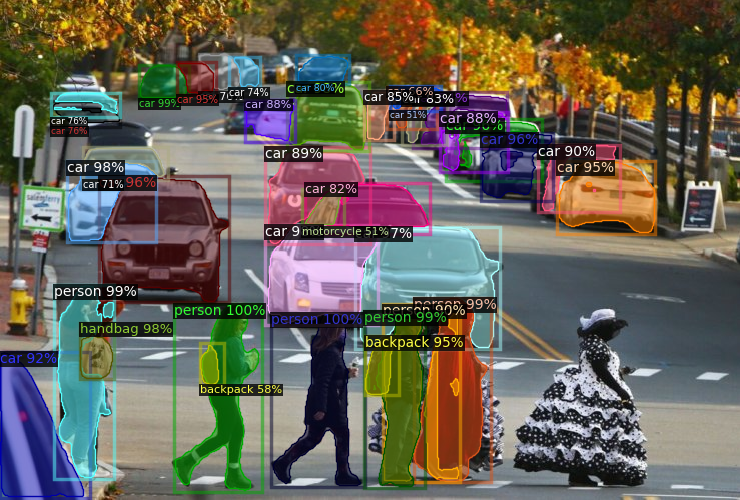

In [6]:
# Inference with instance segmentation - Engineering science fields
cfg_inst = get_cfg() # get new config file
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # Using Mask RCNN R50 model (getting the file)
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # Get the model weights
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(my_new_image)

v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**
<p>
Panoptic segmentation is a computer vision task that combines instance segmentation and semantic segmentation to label every pixel in an image with both a class category and a unique instance ID.

model_final_cafdb1.pkl: 261MB [00:03, 66.8MB/s]                           


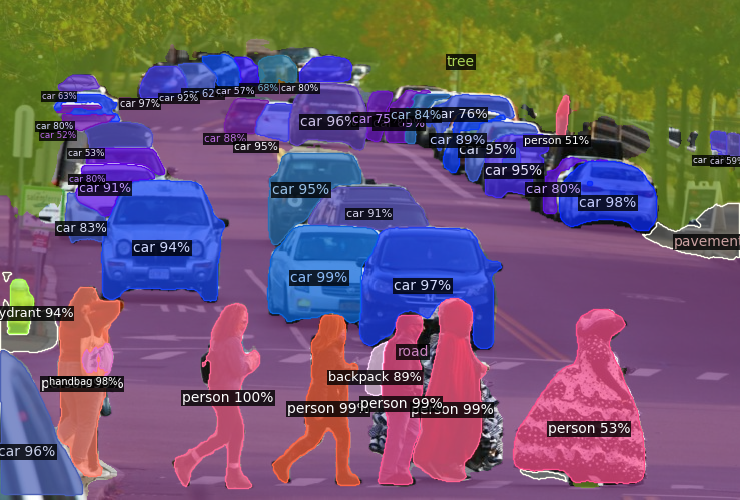

In [7]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(my_new_image)["panoptic_seg"]
v = Visualizer(my_new_image[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

Now that we know the model is working on a natural image, let us test on a scientific image.

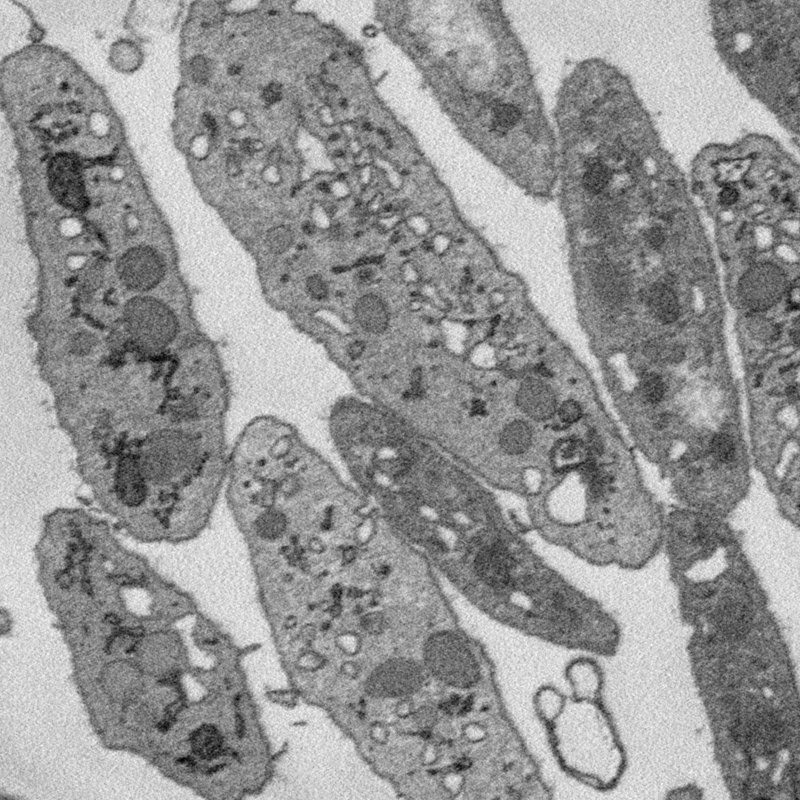

In [9]:
sci_im = cv2.imread("Untitled.png")
cv2_imshow(sci_im)

Let us make some predictions. Remember that the model mask_rcnn_R_50_FPN_3x has no idea about our sample and did not get trained on cells or mitochondria or on any scientific images.

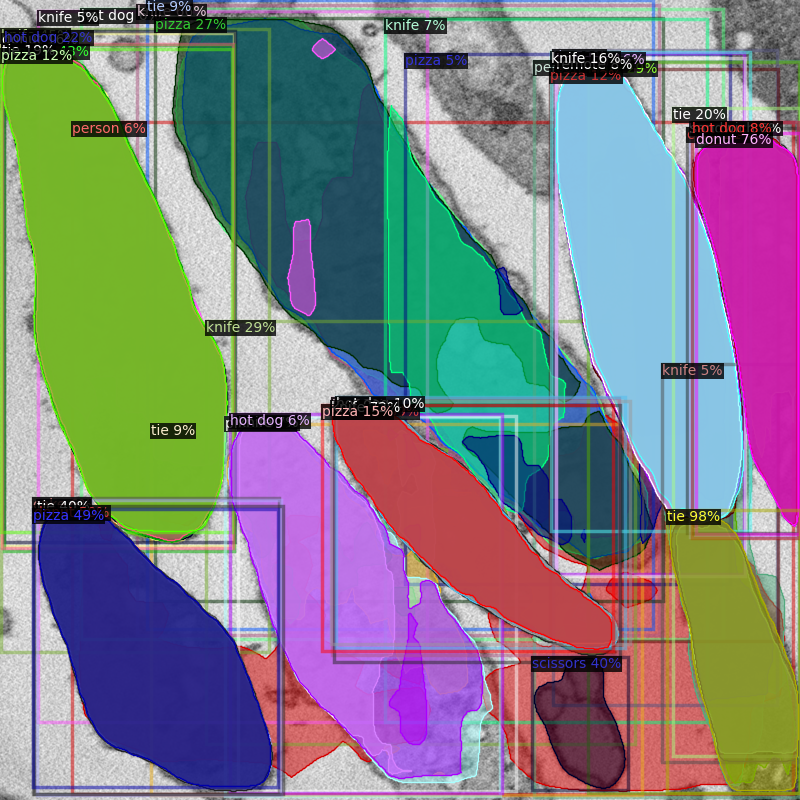

In [10]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])